# Interacting with RuNNer through ASE

_Source: 🤖 [ASE Fork](https://gitlab.com/aknoll/ase/-/tree/enhancement_io_runner) repository_

> ☝ If you need some context about ASE while following this demo, take a look at the 📗 [ASE Documentation](https://wiki.fysik.dtu.dk/ase/index.html).

**In this demo we will:**
1. run a complete RuNNer workflow from scratch on a modified dataset of graphene sheets.
2. see other ways to manage existing calculations with ASE including data loading and analysis.

As a first step, let us load the relevant modules for connecting with RuNNer through ASE: 

In [1]:
import os # Traverse directories etc.

from ase.io import read # Read structural data like input.data files.
import ase.io.runner.runner as io # Read all other file formats with routines belonging to this module.
from ase.calculators.runner.runner import Runner # Set up and perform calculations.

# Optional, but recommended.
from ase.visualize import view # Visualise molecular structures.

We will also define two global variables at this point:

In [2]:
DATA_PATH = '../data/part1' # Path to the data directory
RUNNER_CMD = 'RuNNer.serial.x > PREFIX.out' # Custom command for executing RuNNer in this Binder environment.

## Part 1: Starting a RuNNer Fit From Scratch

The situation is this: we have created a set of graphene structures from LAMMPS simulations and would like to generate a neural network potential for this system. The structures are stored in three separate LAMMPS trajectory files.

**In this section you will:**
   
1. load trajectory files with ASE and combine them into one RuNNer dataset. 
2. learn about ASE calculators.
2. set all relevant RuNNer parameters for this dataset.
3. RuNNer Mode 1: calculate the symmetry function values and inspect the results.
4. RuNNer Mode 2: train a neural network potential and analyse the fit quality and weight distribution. 
5. RuNNer Mode 3: perform a molecular dynamics simulation and visualise the trajectory.

### 1. Loading the dataset

First, we will load the three trajectory files and combine them to a complete dataset.

In [3]:
dataset = []
for file in os.listdir(DATA_PATH):
    if file.endswith('.traj'):
        # The `index=':'` argument makes ASE read the full trajectory instead of the last image only. 
        images = read(os.path.join(DATA_PATH, file), index=':')
        dataset += images

The `dataset` is a long list of ASE `Atoms` objects. Let us take a look at the first entry:

In [4]:
print(dataset[0])

Atoms(symbols='C24', pbc=True, cell=[8.547595992433175, 7.402434992427643, 13.005470990731714], calculator=SinglePointCalculator(...))


As you can see, every `Atoms` object stores information about one structure in the dataset. The short-hand information above summarises the elements involved (called `symbols` in ASE terminology) and the cell geometry. 

Moreover, we can see the `calculator` property. In ASE, when a geometry with energies, forces, etc. is read, this information is stored as a so-called `SinglePointCalculator`.

> **Tip:** You can access further information as class properties, e.g. `dataset[0].positions` will give you the XYZ coordinates of all atoms.

We can also directly make use ASE's built-in visualisation tools:

In [5]:
view(dataset, viewer='ngl')

### 2. Generating the calculator

Take a look at this quote:

> _For ASE, a calculator is a black box that can take atomic numbers and atomic positions from an Atoms object and calculate the energy and forces and sometimes also stresses._
>
> "ASE documentation on Calculators"

As you can see, ASE calculators typically take one atomic configuration and run a DFT code, ReaxFF calculation, EMT, Tersoff potential, etc. in order to retrieve the total energy and atomic forces. The RuNNer calculator, however, needs to be much more flexible. It has to (possibly) access thousands of atomic configurations, perform three completely different types of calculations and store their results. Meanwhile, it has to retain compatibility with the basic functionalities described above.

This gives rise to a few peculiarities which we will get to know in the course of this tutorial.

For now, let us **create an instance** of this calculator class. We are already attaching the dataset during initialisation and also setting the custom command to the Runner executable.

In [6]:
RunnerCalc = Runner(dataset=dataset, command=RUNNER_CMD)

### 3. Setting RuNNer parameters

Upon initialisation, `RunnerCalc` is, by default, equipped with the most common Runner parameters and some sensible default choices. **Nevertheless, you still have access to all RuNNer keywords!** 

Let us take a look at that:

In [7]:
display(RunnerCalc.parameters)

{'runner_mode': 1,
 'elements': None,
 'number_of_elements': None,
 'bond_threshold': 0.5,
 'nn_type_short': 1,
 'use_short_nn': True,
 'optmode_charge': 1,
 'optmode_short_energy': 1,
 'optmode_short_force': 1,
 'points_in_memory': 1000,
 'scale_symmetry_functions': True,
 'cutoff_type': 1,
 'test_fraction': 0.1,
 'random_seed': 0,
 'use_short_forces': True,
 'remove_atom_energies': True,
 'atom_energy': [],
 'epochs': 30,
 'kalman_lambda_short': 0.98,
 'kalman_nue_short': 0.9987,
 'mix_all_points': True,
 'nguyen_widrow_weights_short': True,
 'repeated_energy_update': True,
 'short_energy_error_threshold': 0.1,
 'short_energy_fraction': 1.0,
 'short_force_error_threshold': 1.0,
 'short_force_fraction': 0.1,
 'use_old_weights_charge': False,
 'use_old_weights_short': False,
 'write_weights_epoch': 5,
 'center_symmetry_functions': True,
 'precondition_weights': True,
 'calculate_forces': False,
 'calculate_stress': False,
 'symfunction_short': [],
 'global_activation_short': [None],
 '

The keywords in this dictionary have 
    - a value different from the RuNNer default. These were chosen in order to make usage more convenient. 
    - a value of `None` if they are mandatory for any run and should be immediately visible to the user.
    
For all keywords which do not appear in here, the RuNNer default value is assumed to be fine.

For us, this means that we, as the bare minimum, still have to define `atom_energy`, the symmetry function parameters, and the neural network architecture.

> **Side note**: Admittedly, the NN architecture still is a little cumbersome to specify in this way. 
> In this tutorial I am using the `global_` keywords to make it as easy as possible, but for more complicated 
> systems this quickly becomes unfeasible.
> 
> As you will learn later on, one can always read in an existing input.nn file. Furthermore, I am working on a 
> utility function for this. 

With that in mind, let us go ahead and change some of the default parameters.

In [8]:
RunnerCalc.set(atom_energy=[['C', -8.0/24.0]])
RunnerCalc.set_symmetryfunctions(cutoff=12.0)
RunnerCalc.set(
    global_activation_short=['t', 't', 'l'], 
    global_hidden_layers_short=2, 
    global_nodes_short=[15, 15]
)

{'global_activation_short': ['t', 't', 'l'],
 'global_hidden_layers_short': 2,
 'global_nodes_short': [15, 15]}

Let us inspect the parameters list again.

In [9]:
display(RunnerCalc.parameters)

{'runner_mode': 1,
 'elements': ['C'],
 'number_of_elements': 1,
 'bond_threshold': 0.5,
 'nn_type_short': 1,
 'use_short_nn': True,
 'optmode_charge': 1,
 'optmode_short_energy': 1,
 'optmode_short_force': 1,
 'points_in_memory': 1000,
 'scale_symmetry_functions': True,
 'cutoff_type': 1,
 'test_fraction': 0.1,
 'random_seed': 0,
 'use_short_forces': True,
 'remove_atom_energies': True,
 'atom_energy': [['C', -0.3333333333333333]],
 'epochs': 30,
 'kalman_lambda_short': 0.98,
 'kalman_nue_short': 0.9987,
 'mix_all_points': True,
 'nguyen_widrow_weights_short': True,
 'repeated_energy_update': True,
 'short_energy_error_threshold': 0.1,
 'short_energy_fraction': 1.0,
 'short_force_error_threshold': 1.0,
 'short_force_fraction': 0.1,
 'use_old_weights_charge': False,
 'use_old_weights_short': False,
 'write_weights_epoch': 5,
 'center_symmetry_functions': True,
 'precondition_weights': True,
 'calculate_forces': False,
 'calculate_stress': False,
 'symfunction_short': [['C', 2, 'C', 0.0

### RuNNer Mode 1: Calculating Symmetry Function Values

Now we can go ahead and run the calculation.

In [10]:
RunnerCalc.mode1()

Upon successful termination of the calculation, the calculator will automatically read in the calculation results from the RuNNer output files and store them in a `.results` dictionary. Let's take a look:

In [11]:
print(RunnerCalc.results.keys())

dict_keys(['sfvalues', 'splittraintest'])


In RuNNer Mode 1, the symmetry function values and the split between training and testing set are the relevant output properties. They are stored as dictionaries of numpy arrays.

> **Remark for discussion:** I am thinking about storing them as flattened numpy arrays in a future version of the calculator.

In [12]:
print(RunnerCalc.results['splittraintest'])

{'training': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 61, 62, 63, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 239, 2

### RuNNer Mode 2: Training a Neural Network Potential

The next step is to fit the a neural network potential to the data. For demonstration purposes (and to prevent killing the Binder session) we reduce the number of epochs from 30 to 3.

In [13]:
RunnerCalc.set(epochs=3)

{'epochs': 3}

Now, we can call Mode 2.

In [14]:
RunnerCalc.mode2()
# RunnerCalc = Runner(restart='mode2/mode2', command=RUNNER_CMD) # if the calculation is cancelled due to resources.

In [15]:
print(RunnerCalc.results['fit'])

{'epochs': [0, 1, 2, 3], 'rmse_energy_training': [0.044085, 0.011104, 0.006269, 0.003044], 'rmse_energy_testing': [0.035144, 0.011803, 0.008075, 0.003243], 'rmse_forces_training': [1.246182, 0.532948, 0.243317, 0.123484], 'rmse_forces_testing': [1.278346, 0.554511, 0.244656, 0.129528], 'rmse_charge_training': [], 'rmse_charge_testing': [], 'unit_rmse_energy': 'eV/atom', 'unit_rmse_force': 'eV/atom', 'opt_rmse_epoch': 3}


The module makes it easy to access the fit results and create a simple plot of the data.

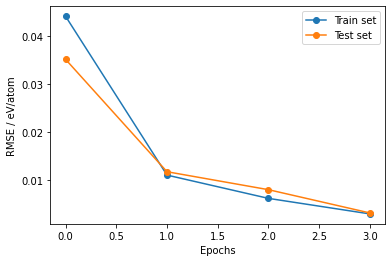

In [16]:
import matplotlib.pyplot as plt

res = RunnerCalc.results['fit']
plt.plot(res['epochs'], res['rmse_energy_training'], 'o-', label='Train set')
plt.plot(res['epochs'], res['rmse_energy_testing'], 'o-', label='Test set')
plt.xlabel('Epochs')
plt.ylabel(f"RMSE / {res['unit_rmse_energy']}")
plt.legend()
plt.show()

One could also inspect the distribution of weights.

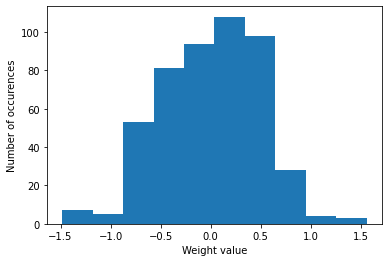

In [17]:
res = RunnerCalc.results['weights']['C']
plt.hist(res)
plt.xlabel('Weight value')
plt.ylabel(f"Number of occurences")
plt.show()

### RuNNer Mode 3: Molecular dynamics simulation

In [48]:
RunnerMD = Runner(restart='mode2/mode2', label='mode3/mode3', command=RUNNER_CMD)
RunnerMD.set(runner_mode=3)
RunnerMD.set(calculate_forces=True)
RunnerCalc.dataset = None

In [49]:
# We want to run MD with constant energy using the VelocityVerlet algorithm.
import ase.units as units
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory

atoms = read(os.path.join(DATA_PATH, 'lammps1.traj'))
atoms.calc = RunnerMD

MaxwellBoltzmannDistribution(atoms, temperature_K=300)
dyn = Langevin(atoms, 1 * units.fs, 300.0 * units.kB, 0.002)

traj = Trajectory('graphene.traj', 'w', atoms)
dyn.attach(traj.write, interval=1)
dyn.run(1)

True

In [40]:
atoms = read('graphene.traj', index=':')
view(atoms, viewer='ngl')

## Part 2: Managing and Analysing Existing Calculations with ASE

Here are a few other ways to interact with RuNNer files through the ASE.

In [21]:
options = io.read_runnerconfig('input.nn')
RunnerCalc = Runner(restart='mode1/mode1')
io.write_traintestforces(
    'trainforces.data', 
    RunnerCalc.dataset, 
    index=RunnerCalc.results['splittraintest']['testing']
)

scaling = io.read_scaling()
weights = io.read_weights()
sfvalues = io.read_functiondata('mode1/function.data')
dataset, options = io.read_runnerase('mode1/mode1')

FileNotFoundError: [Errno 2] No such file or directory: 'input.nn'